In [31]:
import os
import tensorflow as tf

In [32]:
# 根据目录名浏览图片
def get_image_paths(dirctory):
    return [x.path for x in os.scandir(dirctory) if x.name.endswith('.jpg') or x.name.endswith('.png')]

image_A = get_image_paths('C:\\Users\\Administrator\\Desktop\\TF_TransferFace\\trump')
image_B = get_image_paths('C:\\Users\\Administrator\\Desktop\\TF_TransferFace\\cage')


In [33]:
print(len(image_A), len(image_B))

376 318


In [34]:
## 导入包 cv2 numpy
import cv2
import numpy as np
# 批量加载图片方法(根据路径集合)
def load_images(image_paths):
    # 用到cv2 来读取每个路径下的图片，再归入到集合中
    iter_images = [cv2.imread(path) for path in image_paths]
    # 遍历所有图片，将所有图片整合进一个集合中，该集合的shape 为 (batch, width, height, channels)
    for i, image in enumerate(iter_images):
        if i == 0:
            all_iamges = np.empty((len(image_paths),) + image.shape, dtype=image.dtype)
        all_iamges[i] = image
    # 返回该集合
    return all_iamges

trump_images = load_images(image_A[0:3])
cage_images = load_images(image_B[0:3])
print(trump_images.shape)
print(cage_images.shape)



(3, 256, 256, 3)
(3, 256, 256, 3)


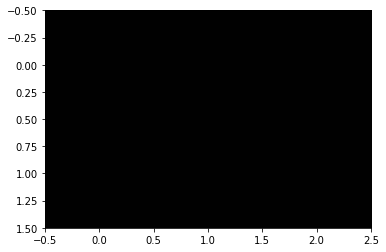

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
# concat 对接成 (6, 256, 256, 3)
figure = np.concatenate((trump_images, cage_images), axis=0)
# reshape成(2, 3, 256, 256, 3)
figure = figure.reshape((2, 3)+ figure.shape[1:])
# 这里需要指定利用 cv 的调色板，否则 plt 展示出来会有色差
plt.imshow(cv2.cvtColor(figure, cv2.COLOR_BGR2RGB))
plt.show()


In [36]:
# 根据所给的维度长度，告诉调用者哪些维度应该被放入第 0 维度，哪些应该被转换为第 1 维度
# 例如 （2,3,256,256,3） 则是第 0 维，第 2 维合在一起，转换成新的图片的第0维（也就是行的个数）
# 第 1 维，第 3 维合在一起，转换成新的图片的第1维（也就是列的个数）
def get_transpose_axes(n):
    # 根据总长度的奇偶性，来制定不同的情况
    if n % 2 == 0:
        y_axes = list(range(1, n-1, 2))
        x_axes = list(range(0, n-1, 2))
    else:
        y_axes = list(range(0, n-1, 2))
        x_axes = list(range(1, n-1, 2))
    return y_axes, x_axes, [n-1]


# 可以将存储多张图片的多维集合，拼成一张图片
def stack_images(images):
    images_shape = np.array(images.shape)
    # new_axes 得到的是三个列表。[0,2],[1,3],[4] 告诉调用者新集合中的每个维度由旧集合中的哪些维度构成
    new_axes = get_transpose_axes(len(images_shape))
    new_shape = [np.prod(images_shape[x]) for x in new_axes]
    return np.transpose(
        images,
        axes=np.concatenate(new_axes)
    ).reshape(new_shape)

In [37]:
# 子像素卷积层，用于上采样
# PixelShuffler layer for Keras
from keras.utils import conv_utils
from keras.engine.topology import Layer
import keras.backend as K


class PixelShuffler(Layer):
    # 初始化 子像素卷积层，并在输入数据时，对数据进行标准化处理。
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')

    def call(self, inputs):
        # 根据得到输入层图层 batch_size，h ，w，c 的大小
        input_shape = K.int_shape(inputs)
        batch_size, h, w, c = input_shape
        if batch_size is None:
            batch_size = -1
        rh, rw = self.size

        # 计算转换后的图层大小与通道数
        oh, ow = h * rh, w * rw
        oc = c // (rh * rw)

        # 先将图层分开，并且将每一层装换到自己应该到维度
        # 最后再利用一次 reshape 函数（计算机会从外到里的一个个的将数据排下来），这就可以转成指定大小的图层了
        out = K.reshape(inputs, (batch_size, h, w, rh, rw, oc))
        out = K.permute_dimensions(out, (0, 1, 3, 2, 4, 5))
        out = K.reshape(out, (batch_size, oh, ow, oc))
        return out

    # compute_output_shape()函数用来输出这一层输出尺寸的大小
    # 尺寸是根据input_shape以及我们定义的output_shape计算的。
    def compute_output_shape(self, input_shape):
        height = input_shape[1] * self.size[0] if input_shape[1] is not None else None
        width = input_shape[2] * self.size[1]  if input_shape[2] is not None else None
        channels = input_shape[3] // self.size[0] // self.size[1]

        return (input_shape[0],
                height,
                width,
                channels)

    # 设置配置文件
    def get_config(self):
        config = {'size': self.size,
                  'data_format': self.data_format}
        base_config = super(PixelShuffler, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


In [38]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D

# 下采样层,filters 为输出图层的通道数
# n * n * c -> 0.5n * 0.5n * filters
def conv(filters):
    def block(x):
        # 每一层由一个使图层大小减小一半的卷积层和一个 LeakyReLU 激活函数层构成。
        x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
        x = LeakyReLU(0.1)(x)
        return x
    return block

# 上采样层，扩大图层大小
# 图层的形状变化如下：
# n*n*c -> n * n * 4filters -> 2n * 2n * filters
def upscale(filters):
    # 每一层由一个扩大通道层的卷积，一个激活函数和一个像素洗牌层
    def block(x):
        # 将通道数扩大为原来的四倍。为了下一步能够通过像素洗牌 使原来的图层扩大两倍
        x = Conv2D(filters*4, kernel_size=3, padding='same')(x)
        x = LeakyReLU(0.1)(x)
        x = PixelShuffler()(x)
        return x
    return block

In [40]:
import tensorflow as tf
# 将原图片转为 Tensor 类型
x1 = tf.convert_to_tensor(trump_images, dtype=tf.float32)
x2 = conv(126)(x1)
x3 = upscale(3)(x2)
print("将大小为 {} 的图片传入 filters 为 126 的下采样层中得到大小为 {} 的图层。".format(x1.shape, x2.shape))
print("将大小为 {} 的图层传入 filters 为  3  的上采样层中得到大小为 {} 的图片。".format(x2.shape, x3.shape))

将大小为 (3, 256, 256, 3) 的图片传入 filters 为 126 的下采样层中得到大小为 (3, 128, 128, 126) 的图层。
将大小为 (3, 128, 128, 126) 的图层传入 filters 为  3  的上采样层中得到大小为 (3, 256, 256, 3) 的图片。
